# Обучение сверточной нейросети на датасете HAM10000

## Импорт необходимых библиотек 

In [6]:
# General
import numpy as np
import matplotlib.pyplot as plt
# PyTorch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch
import torch.optim as optim
# classic ML
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

In [87]:
img_size = 128
num_epochs = 2
batch_size = 10
learning_rate = 0.001

## Перевод изображений в тензоры

Все изображения изначально поделены на папки **train** и **test**. 
В каждой папке изображения лежат по папкам классов. 
На 1 класс одна папка. 
Количество представителей каждого из классов распределены в одинаковых пропорциях в train и test выборке. 
Про то как производилось распределение подробно в [блокноте](https://github.com/gurmaaan/MedNN/blob/master/Sort_img_into_folders.ipynb)

Определяем каскад трансформаций, который будут осуществляться над каждым изображением выборки перед попаданием на обучение / тестирование нейронной сети.

Каскад - массив трансформаций, каждая из которых будет применена к изображению последовательно одна за одной.
Каскад реализуется с помощью _Compose_.
* ToTensor - конвертирует изображение в Тензор 
* Normalize - приводит тензор к нормальному распределению со матожиданием ... и СКО ... МО и СКО указываются для каждой компоненты пикселя 

In [120]:
transformation = [
    transforms.Resize(size=(img_size,img_size)),
    transforms.ToTensor()
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
]
transformation

[Resize(size=(128, 128), interpolation=PIL.Image.BILINEAR), ToTensor()]

Ниже игрушечный пример как работает трансформация изображений

In [121]:
# from PIL import Image
# img = Image.open('image32x32.jpg')
# # d_t = transforms.Compose(transformation)(img)
# d_t = transforms.ToTensor()(img)
# # d_t[компонента цвета][номер столбца в изображении (координата х)] - содержит в себе массив преобразованных координат y данной строки
# len(d_t[0][0])

Теперь дадим понять torch'у к каким изображениям применять описанную выше трансформацию и к каким классам относятся изображения.
Для этого используется класс ImageFolder.
Он загружает папку в которой изображения распиханы по классам-папкам как описано выше. 
```
/root/class1/11.jpg
/root/class1/12.jpg
/root/class2/21.jpg
/root/class2/22.jpg
```

In [122]:
train_folder = ImageFolder(root='train', transform=transforms.Compose(transformation))
test_folder = ImageFolder(root='test', transform=transforms.Compose(transformation))

Теперь я могу узнать размер выборки, распределение по классам, сами классы и т.д.

In [123]:
class_labels = list(train_folder.classes)
num_classes = len(class_labels)
class_labels

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [124]:
len(train_folder)

6710

После этого превратим наши изображения в тренировочную и тестовую выборки для будущей нейросети. 
Для этого используется класс DataLoader.
Он позволяет выдавать случайные выборки и многое другое. 
Выжный параметр деления всей тренировочной выборки на группы:
* batch_size - сколько изображений содержится в 1 группе

In [125]:
train_loader = DataLoader(train_folder, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_folder, batch_size=batch_size, shuffle=True)

len(test_loader) - показывает количество итераций, т.е. сколько батчей во всей выборке
Например, обучающая выборка 6710 фотографий. Размер батча = 100. Тогда итераций будет 6710 / 100 = 68 (т.к. остаются несчастные 10шт в конц) 

In [126]:
len(test_loader)

331

In [127]:
# for ti, tl in test_loader:
#     print(len(ti[0][0]), tl[0])

**Посмотрим что содержится в одном батче**

In [128]:
train_iter = iter(train_loader)

In [129]:
train_images, train_labels = train_iter.next()

In [130]:
classes = train_folder.class_to_idx
classes_map = dict((v,k) for k,v in classes.items())

In [131]:
def label_encoder(class_dict, labels):
    print('Labels:', ' | '.join('%5s' % class_dict[l.item()] for l in labels))

In [132]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(16, 16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

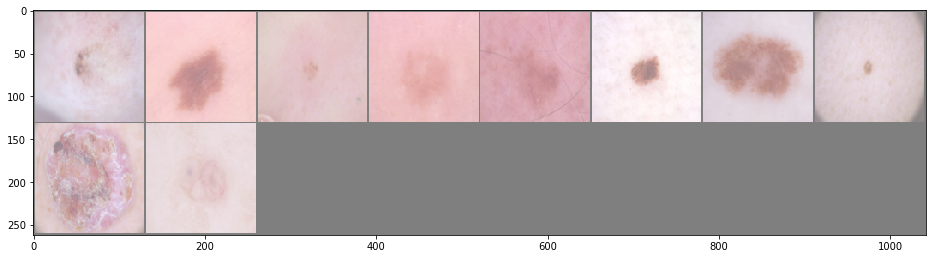

Labels: basal cell carcinoma | nevus | nevus | nevus | nevus | melanoma | melanoma | nevus | basal cell carcinoma | basal cell carcinoma


In [133]:
imshow(torchvision.utils.make_grid(train_images))
label_encoder(classes_map, train_labels)

## Понимание что происходит с размерами

In [134]:
train_images.size()

torch.Size([10, 3, 128, 128])

**Conv2d(3, 6, 5)**

3 = число каналов во входном изображении. 
Например, было 3 компоненты цвета R G B поэтому и каналов 3 .
Это первая компонента размера трехмерного тензора.
Менять нельзя.

6 = число каналов в выходном изображении. Я та ки не понял зачем его увеличивают

5 = размер свертки которой проходятся. Т.е. 5х5 квадратик ползает по изображению и применяет формулу [Cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation)


**MaxPool2d(2,2)**

Первый параметр = размер квадратика которым проходят 

Второй параметр = шаг через который идет квадратик. 

Суть в том что вот квадратик 2х2 проходит, т.е. в нем 4 пикселя. И он выбирает из этих 4 тот у которого значенеи яркости ( или компоненты) наибольшее. И далее формирует новое изображение (тензор) уже другого размера

In [135]:
inp = train_images
print("Input", inp.size())
# print(f"Input tensor: {inps[0]} items where {inps[1]} components of {inps[2]} x {inps[3]} images")

c2d = nn.Conv2d(3, 6, 5)
c22d =  nn.Conv2d(6, 16, 5)
mp = nn.MaxPool2d(2,2)
# ln = nn.Linear()
out = mp(F.relu(c2d(inp)))
out = mp(F.relu(c22d(out)))
out = out.view(-1, 16 * 29 * 29)
print("Output", out.size())
# print(f"Output tensor: {outs[0]} items where {outs[1]} components of {outs[2]} x {outs[3]} images")

Input torch.Size([10, 3, 128, 128])
Output torch.Size([10, 13456])


## Определение архитектуры нейросети

In [167]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [156]:
net = Net()
net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 3, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)


In [157]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

## Обучаем нейросеть 

In [158]:
%%time
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print(f"Epoch {epoch + 1} ------------")
    running_loss = 0.0
    loss_values = [] 
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
#         if torch.cuda.is_available():
#             inputs = inputs.to(torch.device("cuda"))
            
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 100 == 99:    # print every 100 mini-batches
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / len(train_folder)}")
            running_loss = 0.0

print('Finished Training')

Epoch 1 ------------
[1, 100] loss: 0.025213814581204457
[1, 200] loss: 0.017642685304633195
[1, 300] loss: 0.018121195474609
[1, 400] loss: 0.016338016294864536
[1, 500] loss: 0.01740387962401002
[1, 600] loss: 0.017931921395921493
Epoch 2 ------------
[2, 100] loss: 0.017705845948303156
[2, 200] loss: 0.017481014319041803
[2, 300] loss: 0.017070370512818792
[2, 400] loss: 0.017645127211881998
[2, 500] loss: 0.01780508707337159
[2, 600] loss: 0.017219648649013878
Finished Training
Wall time: 2min 37s


## Сохранение выученных коэффициентов

In [5]:
coeff_path = f"NN_coefficients/pytorch_cnn_coeff_{img_size}x{img_size}.pth"
torch.save(net.state_dict(), coeff_path)

'NN_coefficients/pytorch_cnn_coeff_128x128.pth'

## Проверка нейросети на способность предсказания

Сначала грузим реальные картинки и метки классов

In [151]:
test_iter = iter(test_loader)

In [152]:
test_images, test_labels = test_iter.next()

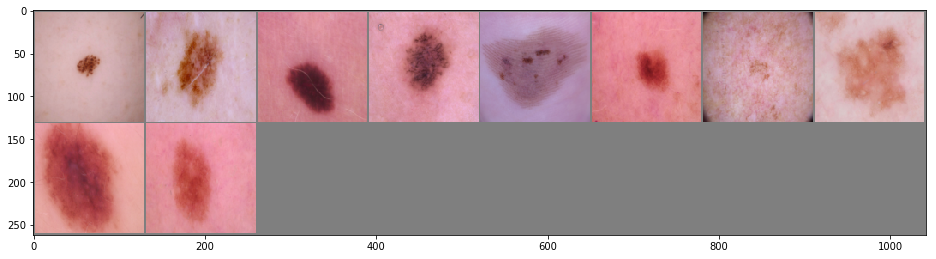

Labels: melanoma | melanoma | nevus | nevus | nevus | nevus | pigmented benign keratosis | nevus | nevus | nevus


In [153]:
imshow(torchvision.utils.make_grid(test_images))
label_encoder(classes_map, test_labels)

Теперь смотрим что угадает сеть

In [154]:
net = Net()
net.load_state_dict(torch.load(coeff_path))

<All keys matched successfully>

In [155]:
outputs = net(test_images)

In [156]:
_, prediction = torch.max(outputs, 1)
label_encoder(classes_map, prediction)

Labels: nevus | nevus | nevus | nevus | pigmented benign keratosis | nevus | basal cell carcinoma | nevus | nevus | nevus


## Оценка accuracy всей валидационной выборки 

In [159]:
real_labels = []
pred_labels = []

In [160]:
%%time
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            real_labels.append(classes_map[labels[i].item()])
            pred_labels.append(classes_map[predicted[i].item()])

In [161]:
result_df = pd.DataFrame(list(zip(real_labels, pred_labels)), columns =['real', 'pred']) 
result_df.head()

,real,pred
0,nevus,nevus
1,pigmented benign keratosis,nevus
2,dermatofibroma,nevus
3,pigmented benign keratosis,nevus
4,melanoma,nevus


In [162]:
result_df['answer'] = result_df.apply(lambda x: int(x['real'] == x['pred']), axis=1)
result_df.head()

,real,pred,answer
0,nevus,nevus,1
1,pigmented benign keratosis,nevus,0
2,dermatofibroma,nevus,0
3,pigmented benign keratosis,nevus,0
4,melanoma,nevus,0


In [163]:
# result_df.to_csv('result.csv', index=False)

In [164]:
print('Accuracy all classes: ', round(accuracy_score(result_df['real'], result_df['pred']) * 100, 2), '%')

Accuracy all classes:  67.35 %


## Оценка accuracy по классам 

In [165]:
classes = result_df['real'].unique()

In [166]:
print(f"Epochs: {num_epochs}")
print(f"Normalization: False")
print('\n')
for cl in classes:
    answ = result_df[result_df['real'] == cl]['answer']
    acc = round(100 * (sum(answ) / len(answ)), 2)
    print(f"{cl} ({len(answ)}): {acc} %")

Epochs: 2
Normalization: False


nevus (2226): 100.0 %
pigmented benign keratosis (343): 0.0 %
dermatofibroma (33): 0.0 %
melanoma (396): 0.0 %
vascular lesion (45): 0.0 %
basal cell carcinoma (165): 0.0 %
actinic keratosis (37): 0.0 %
squamous cell carcinoma (60): 0.0 %
